# **Chicago Car Crashes**

# Overview

# Business Problem

Build a classifier to predict the primary contributory cause of a car accident, given information about the car, the people in the car, the road conditions etc. You might imagine your audience as a Vehicle Safety Board who's interested in reducing traffic accidents, or as the City of Chicago who's interested in becoming aware of any interesting patterns.

This is a multi-class classification problem. You will almost certainly want to bin, trim or otherwise limit the number of target categories on which you ultimately predict. Note that some primary contributory causes have very few samples, for example.

# Data Understanding


In [16]:
# Importing packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Read in Crashes Data
df_crashes = pd.read_csv("data/Traffic_Crashes_-_Crashes.csv", parse_dates=['CRASH_DATE'])

In [18]:
# Read in Vehicles Data
df_vehicles = pd.read_csv("data/Traffic_Crashes_-_Vehicles.csv", parse_dates=['CRASH_DATE'], low_memory=False)

In [19]:
# Read in People Data
df_people = pd.read_csv("data/Traffic_Crashes_-_People.csv", parse_dates=['CRASH_DATE'], low_memory=False)

# EDA

In [ ]:
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778847 entries, 0 to 778846
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH_RECORD_ID                778847 non-null  object        
 1   RD_NO                          774292 non-null  object        
 2   CRASH_DATE_EST_I               58506 non-null   object        
 3   CRASH_DATE                     778847 non-null  datetime64[ns]
 4   POSTED_SPEED_LIMIT             778847 non-null  int64         
 5   TRAFFIC_CONTROL_DEVICE         778847 non-null  object        
 6   DEVICE_CONDITION               778847 non-null  object        
 7   WEATHER_CONDITION              778847 non-null  object        
 8   LIGHTING_CONDITION             778847 non-null  object        
 9   FIRST_CRASH_TYPE               778847 non-null  object        
 10  TRAFFICWAY_TYPE                778847 non-null  object        
 11  

In [ ]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710078 entries, 0 to 1710077
Data columns (total 30 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   PERSON_ID              object        
 1   PERSON_TYPE            object        
 2   CRASH_RECORD_ID        object        
 3   RD_NO                  object        
 4   VEHICLE_ID             float64       
 5   CRASH_DATE             datetime64[ns]
 6   SEAT_NO                float64       
 7   CITY                   object        
 8   STATE                  object        
 9   ZIPCODE                object        
 10  SEX                    object        
 11  AGE                    float64       
 12  DRIVERS_LICENSE_STATE  object        
 13  DRIVERS_LICENSE_CLASS  object        
 14  SAFETY_EQUIPMENT       object        
 15  AIRBAG_DEPLOYED        object        
 16  EJECTION               object        
 17  INJURY_CLASSIFICATION  object        
 18  HOSPITAL              

In [ ]:
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588937 entries, 0 to 1588936
Data columns (total 72 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   CRASH_UNIT_ID             1588937 non-null  int64         
 1   CRASH_RECORD_ID           1588937 non-null  object        
 2   RD_NO                     1579642 non-null  object        
 3   CRASH_DATE                1588937 non-null  datetime64[ns]
 4   UNIT_NO                   1588937 non-null  int64         
 5   UNIT_TYPE                 1586855 non-null  object        
 6   NUM_PASSENGERS            235108 non-null   float64       
 7   VEHICLE_ID                1552556 non-null  float64       
 8   CMRC_VEH_I                29662 non-null    object        
 9   MAKE                      1552551 non-null  object        
 10  MODEL                     1552406 non-null  object        
 11  LIC_PLATE_STATE           1410532 non-null  object

In [ ]:
df_vehicles["CRASH_DATE"].value_counts()

CRASH_DATE
2020-12-29 17:00:00    60
2017-11-10 10:30:00    58
2022-02-17 15:30:00    42
2017-11-10 10:00:00    42
2019-01-12 14:30:00    41
                       ..
2019-11-19 14:23:00     1
2021-12-27 10:40:00     1
2021-12-27 10:03:00     1
2019-11-19 15:39:00     1
2021-07-30 01:30:00     1
Name: count, Length: 510079, dtype: int64

In [ ]:
## Change column names to lowercase for readability
# df_vehicles.columns = df_vehicles.columns.str.lower()

In [ ]:
# Exploring date column - Dec 29th stands out
df_crashes["CRASH_DATE"].value_counts()

CRASH_DATE
2020-12-29 17:00:00    30
2017-11-10 10:30:00    27
2022-02-17 15:30:00    21
2019-01-12 14:30:00    20
2017-11-10 10:00:00    20
                       ..
2020-08-11 13:28:00     1
2018-03-12 13:08:00     1
2018-11-20 18:41:00     1
2018-06-08 02:31:00     1
2020-10-18 00:03:00     1
Name: count, Length: 510053, dtype: int64

In [ ]:
# Convert "CRASH_DATE" to datetime data type
df_crashes["CRASH_DATE"] = pd.to_datetime(df_crashes["CRASH_DATE"])

# Extract the month from "CRASH_DATE"
df_crashes["Month"] = df_crashes["CRASH_DATE"].dt.month

# Count occurrences of each month
month_counts = df_crashes["Month"].value_counts()

# Identify the month with the highest count
most_common_month = month_counts.idxmax()
most_common_month

10

In [ ]:
# The day of the week component of CRASH_DATE. Sunday=1
df_crashes["CRASH_DAY_OF_WEEK"].value_counts()

CRASH_DAY_OF_WEEK
6    126522
7    115291
5    111692
3    111060
4    110361
2    107243
1     96678
Name: count, dtype: int64

In [ ]:
# Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer
injuries_counts = df_crashes["INJURIES_TOTAL"].value_counts()
injuries_counts

INJURIES_TOTAL
0.0     670544
1.0      80305
2.0      17802
3.0       5393
4.0       1929
5.0        683
6.0        274
7.0        104
8.0         43
9.0         24
10.0        14
11.0         8
15.0         7
21.0         4
12.0         4
13.0         2
17.0         1
14.0         1
19.0         1
16.0         1
Name: count, dtype: int64

In [ ]:
# Fatal injuries
injuries_fatal = df_crashes["INJURIES_FATAL"].value_counts()
injuries_fatal

INJURIES_FATAL
0.0    776287
1.0       796
2.0        52
3.0         8
4.0         1
Name: count, dtype: int64

In [ ]:
df_crashes["CRASH_TYPE"].value_counts()

CRASH_TYPE
NO INJURY / DRIVE AWAY              571926
INJURY AND / OR TOW DUE TO CRASH    206921
Name: count, dtype: int64

In [ ]:
df_crashes["FIRST_CRASH_TYPE"].value_counts()

FIRST_CRASH_TYPE
PARKED MOTOR VEHICLE            181193
REAR END                        175239
SIDESWIPE SAME DIRECTION        118693
TURNING                         110954
ANGLE                            84304
FIXED OBJECT                     36601
PEDESTRIAN                       17941
PEDALCYCLIST                     11880
SIDESWIPE OPPOSITE DIRECTION     11020
OTHER OBJECT                      7729
REAR TO FRONT                     7257
HEAD ON                           6650
REAR TO SIDE                      4312
OTHER NONCOLLISION                2486
REAR TO REAR                      1516
ANIMAL                             553
OVERTURNED                         477
TRAIN                               42
Name: count, dtype: int64

In [ ]:
df_crashes["PRIM_CONTRIBUTORY_CAUSE"].value_counts()

PRIM_CONTRIBUTORY_CAUSE
UNABLE TO DETERMINE                                                                 302153
FAILING TO YIELD RIGHT-OF-WAY                                                        85315
FOLLOWING TOO CLOSELY                                                                76341
NOT APPLICABLE                                                                       41267
IMPROPER OVERTAKING/PASSING                                                          38280
FAILING TO REDUCE SPEED TO AVOID CRASH                                               32933
IMPROPER BACKING                                                                     30962
IMPROPER LANE USAGE                                                                  28112
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  25874
IMPROPER TURNING/NO SIGNAL                                                           25859
DISREGARDING TRAFFIC SIGNALS                                      

In [ ]:
# Filtering by removing Unable to determine cause
# Total decreases from 778437 to 476K 
df_crashes[df_crashes["PRIM_CONTRIBUTORY_CAUSE"] != "UNABLE TO DETERMINE"]


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,Month
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,JG387648,NaN,2023-08-18 12:50:00,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN,8
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,JG361138,NaN,2023-07-29 14:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952),7
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,JG388133,NaN,2023-08-18 17:58:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,...,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006),8
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,JG387475,NaN,2023-08-18 10:45:00,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,...,0.0,1.0,0.0,10,6,8,NaN,NaN,NaN,8
7,0e208d23344f0d1b3a9fcd4bb07676a750ddb73c397b5c...,JG381551,NaN,2023-08-13 13:30:00,35,NO CONTROLS,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,ANGLE,...,0.0,2.0,0.0,13,1,8,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778835,e38400c0474e70f5aa9f0e0f115957281ff234b6727e00...,JD213164,NaN,2020-04-20 15:30:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,2.0,0.0,15,2,4,41.740031,-87.629704,POINT (-87.629704407703 41.74003058451),4
778838,89dc61af34d393db950397f0cc06d53b56d1f5e5fa14d4...,JG317141,NaN,2023-06-26 16:50:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,...,0.0,4.0,0.0,16,2,6,41.746905,-87.644077,POINT (-87.644077151581 41.746904607442),6
778840,3d00cf22a912d0e18809db862dd67e5812f7b6af1ffa3d...,JG346351,NaN,2023-07-18 14:10:00,30,UNKNOWN,UNKNOWN,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,...,0.0,2.0,0.0,14,3,7,41.778580,-87.738679,POINT (-87.738679437114 41.77857996073),7
778842,6dee8823d4ae96624b741428681d19f50b5960418b6d79...,JG408597,NaN,2023-09-02 18:25:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,2.0,0.0,18,7,9,41.758092,-87.624902,POINT (-87.624902228247 41.758092176383),9


In [ ]:
df_crashes['WEATHER_CONDITION'].value_counts()

WEATHER_CONDITION
CLEAR                       613562
RAIN                         67442
UNKNOWN                      41911
SNOW                         26623
CLOUDY/OVERCAST              22893
OTHER                         2404
FREEZING RAIN/DRIZZLE         1407
FOG/SMOKE/HAZE                1110
SLEET/HAIL                     943
BLOWING SNOW                   398
SEVERE CROSS WIND GATE         147
BLOWING SAND, SOIL, DIRT         7
Name: count, dtype: int64

In [ ]:
# columns to drop
#df_crashes.drop( rd_no, crash_date_est_i, report_type, data_police-Notified, sec_contributory_cause, street_no, street_direction, street_name, beat_of_occurence, photos_taken, statements_taken, work_zone_i, latitute, longitute, location  


CRASH_DATE_EST_I
Y    51001
N     7505
Name: count, dtype: int64

In [ ]:
# columns to drop
# df_vehicles (rd_no, unit_no, unit_type, vehicle_id, travel_direciton, towed_i, fire_i, occupant_count, towed_by, towed_to, area_all, cmv_id, usdot_not, ccmc_no, ilcc_no, commercial_src, gvwr, carrier_name, carrier_state, carrier_city, hazmat_placards_i, 
# hazmat_name, un_no, hazmat_present_i, hazmat_report_i, hazmat_report_no, mcs_report_all, drop the rest, keep total_vehicle_length and vehicle_config, drop cargo_body_type, ) trucks 

In [ ]:
# keep columns in people data 
# sex, age, safety_equipment, airbag, injury classfication, driver_action, vision, physical_condi, ped location, bac, cell use

In [ ]:
# Exploring Vehicles Dataset
df_vehicles["CRASH_DATE"].value_counts()

CRASH_DATE
12/29/2020 05:00:00 PM    60
11/10/2017 10:30:00 AM    58
02/17/2022 03:30:00 PM    42
11/10/2017 10:00:00 AM    42
01/12/2019 02:30:00 PM    41
                          ..
11/19/2019 02:23:00 PM     1
12/27/2021 10:40:00 AM     1
12/27/2021 10:03:00 AM     1
11/19/2019 03:39:00 PM     1
07/30/2021 01:30:00 AM     1
Name: count, Length: 510079, dtype: int64

In [ ]:
df_vehicles["CMRC_VEH_I"].value_counts()

CMRC_VEH_I
Y    18958
N    10704
Name: count, dtype: int64

In [ ]:
# Exploring the People Dataset
df_people['CRASH_DATE'].value_counts()

CRASH_DATE
2020-12-29 17:00:00    72
2017-11-10 10:30:00    64
2018-03-16 10:17:00    61
2019-06-22 18:15:00    55
2023-07-12 10:40:00    50
                       ..
2018-01-02 20:52:00     1
2020-02-11 00:10:00     1
2018-01-02 20:28:00     1
2021-02-24 18:39:00     1
2015-11-22 13:58:00     1
Name: count, Length: 509164, dtype: int64

In [ ]:
# Converting CRASH_DATE to datetime to explore months and years of crashes

df_people['CRASH_DATE'] = pd.to_datetime(df_people['CRASH_DATE'])

# Create new columns for month and year
df_people['Month'] = df_people['CRASH_DATE'].dt.month
df_people['Year'] = df_people['CRASH_DATE'].dt.year

# Sort the DataFrame by year
sorted_df = df_people.sort_values(by=['Year'])

# Count the crashes for each year
crash_counts_by_year = sorted_df.groupby(['Year']).size().reset_index(name='Crash_Count')

# Print the result
print(crash_counts_by_year)


    Year  Crash_Count
0   2013            5
1   2014           11
2   2015        20933
3   2016        96022
4   2017       185328
5   2018       265709
6   2019       264007
7   2020       199983
8   2021       233794
9   2022       233819
10  2023       210467


In [ ]:
# Driver action that contributed to the crash, as determined by reporting officer
df_people["DRIVER_ACTION"].value_counts()

DRIVER_ACTION
NONE                                 488224
UNKNOWN                              340884
FAILED TO YIELD                      123908
OTHER                                121181
FOLLOWED TOO CLOSELY                  81516
IMPROPER BACKING                      40766
IMPROPER TURN                         35662
IMPROPER LANE CHANGE                  35018
IMPROPER PASSING                      30330
DISREGARDED CONTROL DEVICES           23852
TOO FAST FOR CONDITIONS               20583
WRONG WAY/SIDE                         5441
IMPROPER PARKING                       5029
OVERCORRECTED                          2403
EVADING POLICE VEHICLE                 2152
CELL PHONE USE OTHER THAN TEXTING      2038
EMERGENCY VEHICLE ON CALL              1240
TEXTING                                 543
STOPPED SCHOOL BUS                      164
LICENSE RESTRICTIONS                     56
Name: count, dtype: int64

In [ ]:
# Status of blood alcohol concentration testing for driver or other person involved in crash
df_people["BAC_RESULT"].value_counts()

BAC_RESULT
TEST NOT OFFERED                   1341864
TEST REFUSED                         14318
TEST PERFORMED, RESULTS UNKNOWN       3347
TEST TAKEN                            2440
Name: count, dtype: int64

In [ ]:
df_people["BAC_RESULT VALUE"].value_counts()

BAC_RESULT VALUE
0.00    190
0.18    134
0.17    129
0.21    116
0.14    109
0.20    102
0.16     99
0.19     91
0.15     82
0.22     80
0.23     75
0.11     72
0.13     71
0.12     70
0.24     65
0.26     48
0.25     45
0.10     36
0.27     35
0.09     33
0.28     32
0.08     25
0.29     19
0.07     18
0.30     17
0.03     17
0.33     16
0.04     15
0.05     11
0.32     10
0.35      9
0.02      8
0.31      8
0.06      8
0.38      7
0.36      4
0.34      4
0.39      3
0.44      3
0.01      3
1.00      2
0.79      2
0.88      2
0.45      2
0.60      2
0.95      1
0.40      1
0.47      1
0.99      1
0.41      1
0.80      1
0.58      1
0.37      1
0.85      1
0.67      1
0.98      1
Name: count, dtype: int64

In [ ]:
# Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer
df_people["CELL_PHONE_USE"].value_counts()

CELL_PHONE_USE
Y    752
N    406
Name: count, dtype: int64

In [ ]:
df_people["INJURY_CLASSIFICATION"].value_counts()

INJURY_CLASSIFICATION
NO INDICATION OF INJURY     1561840
NONINCAPACITATING INJURY      83359
REPORTED, NOT EVIDENT         47454
INCAPACITATING INJURY         15765
FATAL                           949
Name: count, dtype: int64

# Filtering

In [20]:
# Filtering data from 2020-2023
df_crashes = df_crashes[df_crashes["CRASH_DATE"].dt.year >= 2020]
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404215 entries, 0 to 778846
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH_RECORD_ID                404215 non-null  object        
 1   RD_NO                          399660 non-null  object        
 2   CRASH_DATE_EST_I               30637 non-null   object        
 3   CRASH_DATE                     404215 non-null  datetime64[ns]
 4   POSTED_SPEED_LIMIT             404215 non-null  int64         
 5   TRAFFIC_CONTROL_DEVICE         404215 non-null  object        
 6   DEVICE_CONDITION               404215 non-null  object        
 7   WEATHER_CONDITION              404215 non-null  object        
 8   LIGHTING_CONDITION             404215 non-null  object        
 9   FIRST_CRASH_TYPE               404215 non-null  object        
 10  TRAFFICWAY_TYPE                404215 non-null  object        
 11  LANE_

In [21]:
df_people = df_people[df_people["CRASH_DATE"].dt.year >= 2020]
df_people.info()

<class 'pandas.core.frame.DataFrame'>
Index: 878063 entries, 1 to 1710077
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   PERSON_ID              878063 non-null  object        
 1   PERSON_TYPE            878063 non-null  object        
 2   CRASH_RECORD_ID        878063 non-null  object        
 3   RD_NO                  867983 non-null  object        
 4   VEHICLE_ID             860214 non-null  float64       
 5   CRASH_DATE             878063 non-null  datetime64[ns]
 6   SEAT_NO                175016 non-null  float64       
 7   CITY                   626532 non-null  object        
 8   STATE                  638522 non-null  object        
 9   ZIPCODE                574270 non-null  object        
 10  SEX                    862085 non-null  object        
 11  AGE                    613798 non-null  float64       
 12  DRIVERS_LICENSE_STATE  506558 non-null  object  

In [22]:
df_vehicles = df_vehicles[df_vehicles["CRASH_DATE"].dt.year >= 2020]
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 827820 entries, 0 to 1588936
Data columns (total 72 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CRASH_UNIT_ID             827820 non-null  int64         
 1   CRASH_RECORD_ID           827820 non-null  object        
 2   RD_NO                     818525 non-null  object        
 3   CRASH_DATE                827820 non-null  datetime64[ns]
 4   UNIT_NO                   827820 non-null  int64         
 5   UNIT_TYPE                 826872 non-null  object        
 6   NUM_PASSENGERS            120706 non-null  float64       
 7   VEHICLE_ID                808925 non-null  float64       
 8   CMRC_VEH_I                15797 non-null   object        
 9   MAKE                      808920 non-null  object        
 10  MODEL                     808785 non-null  object        
 11  LIC_PLATE_STATE           726826 non-null  object        
 12  VEHICL

In [23]:
df_vehicles = df_vehicles[
    (df_vehicles["VEHICLE_TYPE"] == "PASSENGER") |
    (df_vehicles["VEHICLE_TYPE"] == "SPORT UTILITY VEHICLE (SUV)") |
    (df_vehicles["VEHICLE_TYPE"] == "VAN/MINI-VAN")
]

In [24]:
# sanity check
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655416 entries, 0 to 1588936
Data columns (total 72 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CRASH_UNIT_ID             655416 non-null  int64         
 1   CRASH_RECORD_ID           655416 non-null  object        
 2   RD_NO                     648046 non-null  object        
 3   CRASH_DATE                655416 non-null  datetime64[ns]
 4   UNIT_NO                   655416 non-null  int64         
 5   UNIT_TYPE                 655410 non-null  object        
 6   NUM_PASSENGERS            108294 non-null  float64       
 7   VEHICLE_ID                655416 non-null  float64       
 8   CMRC_VEH_I                2771 non-null    object        
 9   MAKE                      655411 non-null  object        
 10  MODEL                     655295 non-null  object        
 11  LIC_PLATE_STATE           614177 non-null  object        
 12  VEHICL

In [25]:
# Filter for total injuries column
df_crashes = df_crashes[df_crashes["INJURIES_TOTAL"] > 0]
df_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60859 entries, 0 to 778844
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH_RECORD_ID                60859 non-null  object        
 1   RD_NO                          60098 non-null  object        
 2   CRASH_DATE_EST_I               3160 non-null   object        
 3   CRASH_DATE                     60859 non-null  datetime64[ns]
 4   POSTED_SPEED_LIMIT             60859 non-null  int64         
 5   TRAFFIC_CONTROL_DEVICE         60859 non-null  object        
 6   DEVICE_CONDITION               60859 non-null  object        
 7   WEATHER_CONDITION              60859 non-null  object        
 8   LIGHTING_CONDITION             60859 non-null  object        
 9   FIRST_CRASH_TYPE               60859 non-null  object        
 10  TRAFFICWAY_TYPE                60859 non-null  object        
 11  LANE_CNT           

In [26]:
# Merge Datasets
df_joined = pd.merge(df_crashes, pd.merge(df_vehicles, df_people, on="CRASH_RECORD_ID"), on="CRASH_RECORD_ID")
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305598 entries, 0 to 305597
Columns: 149 entries, CRASH_RECORD_ID to CELL_PHONE_USE
dtypes: datetime64[ns](3), float64(24), int64(8), object(114)
memory usage: 347.4+ MB


In [27]:
# Dropping columns

columns_to_drop_crashes = ['RD_NO', 'CRASH_DATE_EST_I', 'LANE_CNT', 'REPORT_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DATE_POLICE_NOTIFIED',
                           'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I',
                           'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
                           'INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE', 'LOCATION'
                           ]

columns_to_drop_vehicles = ['RD_NO', 'CRASH_DATE', 'CRASH_UNIT_ID', 'UNIT_NO', 'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE', 'MODEL', 'VEHICLE_YEAR',
                            'VEHICLE_DEFECT','VEHICLE_USE', 'TRAVEL_DIRECTION', 'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_TO',
                            'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I',
                            'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',  'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC',
                            'GVWR', 'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME','UN_NO', 'HAZMAT_PRESENT_I',
                            'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO',
                            'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'VEHICLE_CONFIG', 'CARGO_BODY_TYPE',
                            'LOAD_TYPE', 'HAZMAT_OUT_OF_SERVICE_I', 'MCS_OUT_OF_SERVICE_I', 'HAZMAT_CLASS'
                            ]

columns_to_drop_people = ['RD_NO', 'CRASH_DATE', 'VEHICLE_ID', 'PERSON_ID', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'EJECTION',
                          'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'BAC_RESULT VALUE', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'CELL_PHONE_USE', 'INJURY_CLASSIFICATION'
                          ]

df_crashes = df_crashes.drop(columns_to_drop_crashes, axis=1)
df_vehicles = df_vehicles.drop(columns_to_drop_vehicles, axis=1)
df_people = df_people.drop(columns_to_drop_people, axis=1)

In [28]:
# joining all dataframes into master df
master_df = pd.merge(df_crashes, pd.merge(df_vehicles, df_people, on="CRASH_RECORD_ID"), on="CRASH_RECORD_ID")

In [29]:
# Sanity Check
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305598 entries, 0 to 305597
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          305598 non-null  object        
 1   CRASH_DATE               305598 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       305598 non-null  int64         
 3   TRAFFIC_CONTROL_DEVICE   305598 non-null  object        
 4   DEVICE_CONDITION         305598 non-null  object        
 5   WEATHER_CONDITION        305598 non-null  object        
 6   LIGHTING_CONDITION       305598 non-null  object        
 7   FIRST_CRASH_TYPE         305598 non-null  object        
 8   TRAFFICWAY_TYPE          305598 non-null  object        
 9   ALIGNMENT                305598 non-null  object        
 10  ROADWAY_SURFACE_COND     305598 non-null  object        
 11  ROAD_DEFECT              305598 non-null  object        
 12  CRASH_TYPE      

In [ ]:
master_df["CRASH_DATE"] = pd.to_datetime(master_df["CRASH_DATE"])
master_df["CRASH_YEAR"] = master_df["CRASH_DATE"].dt.year
year_counts = master_df["CRASH_YEAR"].value_counts()
print(year_counts)

In [14]:
pd.set_option('display.max_rows', None)
df_joined.isna().sum()

CRASH_RECORD_ID                       0
RD_NO                              3652
CRASH_DATE_EST_I                 291257
CRASH_DATE                            0
POSTED_SPEED_LIMIT                    0
TRAFFIC_CONTROL_DEVICE                0
DEVICE_CONDITION                      0
WEATHER_CONDITION                     0
LIGHTING_CONDITION                    0
FIRST_CRASH_TYPE                      0
TRAFFICWAY_TYPE                       0
LANE_CNT                         305538
ALIGNMENT                             0
ROADWAY_SURFACE_COND                  0
ROAD_DEFECT                           0
REPORT_TYPE                       28512
CRASH_TYPE                            0
INTERSECTION_RELATED_I           161198
NOT_RIGHT_OF_WAY_I               297834
HIT_AND_RUN_I                    234842
DAMAGE                                0
DATE_POLICE_NOTIFIED                  0
PRIM_CONTRIBUTORY_CAUSE               0
SEC_CONTRIBUTORY_CAUSE                0
STREET_NO                             0


# Missing Values

In [ ]:
Safety_equipment
Airbag_deployed
injury_classification 


In [69]:
df_joined["DRIVER_VISION"].value_counts(dropna=False)

DRIVER_VISION
NOT OBSCURED              105839
NaN                        96665
UNKNOWN                    96639
OTHER                       2541
MOVING VEHICLES             1713
PARKED VEHICLES              927
WINDSHIELD (WATER/ICE)       559
BLINDED - SUNLIGHT           427
TREES, PLANTS                 90
BUILDINGS                     79
BLINDED - HEADLIGHTS          43
BLOWING MATERIALS             24
HILLCREST                     22
EMBANKMENT                    20
SIGNBOARD                     10
Name: count, dtype: int64

**Injury_classification**

injuries_total = Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer

Injury severity = Severity of injury person sustained in the crash
The missing values 65 are a small percentage. Since it's not significant, we could drop or Could replace it with Mode

In [48]:
# Injuries total reports total injuries 
df_joined["INJURY_CLASSIFICATION"].value_counts(dropna=False)

INJURY_CLASSIFICATION
NO INDICATION OF INJURY     156072
NONINCAPACITATING INJURY     85784
REPORTED, NOT EVIDENT        48512
INCAPACITATING INJURY        14282
FATAL                          883
NaN                             65
Name: count, dtype: int64

In [57]:
nan_rows = df_joined[df_joined["INJURY_CLASSIFICATION"].isna()]
nan_rows.head()

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,...,PERSON_TYPE,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,INJURY_CLASSIFICATION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,BAC_RESULT
1735,3ee40633f80b551a782da504d4f4e2a7461d4eb21d37ec...,2020-05-02 21:09:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",HEAD ON,NOT DIVIDED,STRAIGHT AND LEVEL,...,PASSENGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1741,3ee40633f80b551a782da504d4f4e2a7461d4eb21d37ec...,2020-05-02 21:09:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",HEAD ON,NOT DIVIDED,STRAIGHT AND LEVEL,...,PASSENGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8624,02b4fb68fea47d460d68d0d2351900d400f512d6bb044a...,2020-07-12 00:20:00,25,STOP SIGN/FLASHER,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,...,PASSENGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9677,03bba5bf5967ed0aba9b197af4c3b4db9f05fc4842709a...,2022-09-21 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,PASSENGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9681,03bba5bf5967ed0aba9b197af4c3b4db9f05fc4842709a...,2022-09-21 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,PASSENGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
mode_value = df_joined["INJURY_CLASSIFICATION"].mode()[0]
mode_value 
# df_joined["INJURY_CLASSIFICATION"].fillna(mode_value, inplace=True)

'NO INDICATION OF INJURY'

In [67]:
print("Percentages")
print(df_joined["INJURY_CLASSIFICATION"].value_counts(normalize=True, dropna=False))

Percentages
INJURY_CLASSIFICATION
NO INDICATION OF INJURY     0.510710
NONINCAPACITATING INJURY    0.280709
REPORTED, NOT EVIDENT       0.158744
INCAPACITATING INJURY       0.046735
FATAL                       0.002889
NaN                         0.000213
Name: proportion, dtype: float64


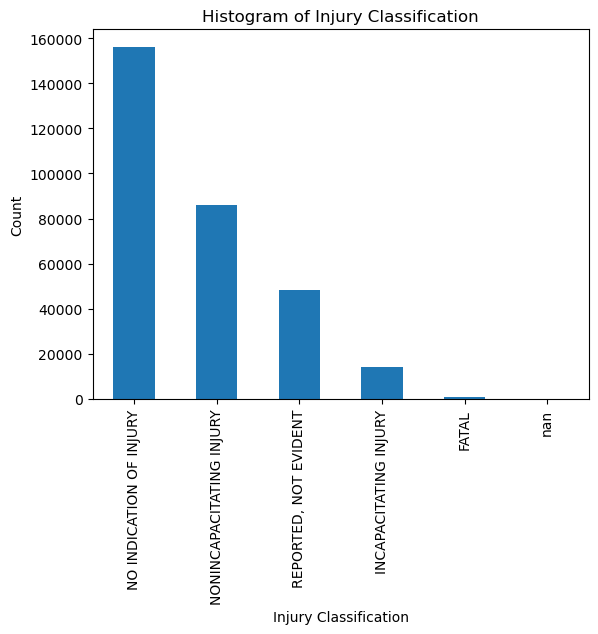

In [63]:
df_joined["INJURY_CLASSIFICATION"].value_counts(dropna=False).plot(kind='bar')
plt.xlabel("Injury Classification")
plt.ylabel("Count")
plt.title("Histogram of Injury Classification")
plt.show()


Airbag_deployed = Whether vehicle occupant airbag deployed as result of crash. Drop the nulls? 
We could create a binary flag or tertiary feature as Airbag_deployed, not_deployed, unknown

In [50]:
df_joined["AIRBAG_DEPLOYED"].value_counts(dropna=False)

AIRBAG_DEPLOYED
DID NOT DEPLOY                            103772
NOT APPLICABLE                             65839
DEPLOYED, COMBINATION                      39428
DEPLOYMENT UNKNOWN                         39380
DEPLOYED, FRONT                            34918
NaN                                        11910
DEPLOYED, SIDE                              9692
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       659
Name: count, dtype: int64

In [66]:
print("Percentages")
print(df_joined["AIRBAG_DEPLOYED"].value_counts(normalize=True, dropna=False))

Percentages
AIRBAG_DEPLOYED
DID NOT DEPLOY                            0.339570
NOT APPLICABLE                            0.215443
DEPLOYED, COMBINATION                     0.129019
DEPLOYMENT UNKNOWN                        0.128862
DEPLOYED, FRONT                           0.114261
NaN                                       0.038973
DEPLOYED, SIDE                            0.031715
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)    0.002156
Name: proportion, dtype: float64


safety_equipment = Safety equipment used by vehicle occupant in crash, if any

In [53]:
df_joined["SAFETY_EQUIPMENT"].value_counts(dropna=False)

SAFETY_EQUIPMENT
USAGE UNKNOWN                                 148302
SAFETY BELT USED                              130454
NONE PRESENT                                   12736
HELMET NOT USED                                 3233
SAFETY BELT NOT USED                            2645
NaN                                             1633
CHILD RESTRAINT - FORWARD FACING                1623
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)      1540
CHILD RESTRAINT - TYPE UNKNOWN                  1075
CHILD RESTRAINT - REAR FACING                    733
DOT COMPLIANT MOTORCYCLE HELMET                  520
BOOSTER SEAT                                     417
CHILD RESTRAINT NOT USED                         320
CHILD RESTRAINT USED IMPROPERLY                  112
WHEELCHAIR                                        76
NOT DOT COMPLIANT MOTORCYCLE HELMET               76
SHOULD/LAP BELT USED IMPROPERLY                   73
HELMET USED                                       15
STRETCHER                    

In [62]:
print("Percentages")
print(df_joined["SAFETY_EQUIPMENT"].value_counts(normalize=True, dropna=False))

Percentages
SAFETY_EQUIPMENT
USAGE UNKNOWN                                 0.485285
SAFETY BELT USED                              0.426881
NONE PRESENT                                  0.041676
HELMET NOT USED                               0.010579
SAFETY BELT NOT USED                          0.008655
NaN                                           0.005344
CHILD RESTRAINT - FORWARD FACING              0.005311
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)    0.005039
CHILD RESTRAINT - TYPE UNKNOWN                0.003518
CHILD RESTRAINT - REAR FACING                 0.002399
DOT COMPLIANT MOTORCYCLE HELMET               0.001702
BOOSTER SEAT                                  0.001365
CHILD RESTRAINT NOT USED                      0.001047
CHILD RESTRAINT USED IMPROPERLY               0.000366
WHEELCHAIR                                    0.000249
NOT DOT COMPLIANT MOTORCYCLE HELMET           0.000249
SHOULD/LAP BELT USED IMPROPERLY               0.000239
HELMET USED                         